# Estudio COVID-19
Objetivo de este notebook:
- Analizar contagios por rango etario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Para realizar esta sección se tomaron [datos del Ministerio de salud](http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina), los datos que vamos a tomar son para analizar la cantidad de contagiados por rango etario y se añadirá un pequeño analisis comparando los contagiados por el sexo. Del datasets original podemos ver que tenemos:

In [2]:
path_Covid19Casos_25_09 = '/home/franco/Documentos/Python/Clones/republica-liberal/COVID-19_Ar/datasetsCovid/Covid19Casos-25-09.csv'
df = pd.read_csv(path_Covid19Casos_25_09)
df.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2020-09-25
1,1000002,M,21.0,Años,Argentina,Buenos Aires,La Matanza,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2020-06-01,427,2020-09-25
2,1000003,F,40.0,Años,Argentina,Córdoba,Capital,Córdoba,2020-05-24,2020-06-01,...,NaN,NO,14,Privado,Caso Descartado,Descartado,14,2020-06-01,14,2020-09-25
3,1000005,F,58.0,Años,Argentina,Mendoza,Las Heras,Mendoza,NaN,2020-06-01,...,NaN,NO,50,Público,Caso Descartado,Descartado,50,2020-06-01,49,2020-09-25
4,1000006,M,28.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Buenos Aires,2020-05-30,2020-06-01,...,NaN,NO,6,Público,Caso sospechoso - Con muestra sin resultado,Sospechoso,6,NaN,515,2020-09-25


# Organizando dataset para estudio

In [3]:
df['fallecido'] = df['fallecido'].replace("SI", 1)
df['fallecido'] = df['fallecido'].replace("NO", 0)

In [4]:
df['clasificacion_resumen'].value_counts()

Descartado        1003458
Confirmado         691230
Sospechoso         146139
Sin Clasificar        372
Name: clasificacion_resumen, dtype: int64

Tomaremos los datos confirmados. El dataset en bruto tiene 25 columnas. Las de interés nuestro son el sexo, edad, fecha de diagnóstico, la columna que indica si se encuentra fallecido o no y en que fecha fallecio.

Luego de limpiar los datos lo que haremos será obtener subdatasets de este y normalizarlos para realizar el estudio.

## Tratamiento de datos

In [5]:
# Filtro para confirmados
classFilter = (df.clasificacion_resumen == 'Confirmado')
df_confirmados = df.loc[classFilter]

# Seleccion de columnas para estudio
columnas_interes = ['sexo', 'edad', 'clasificacion_resumen', 'fecha_diagnostico', 'fallecido', 'fecha_fallecimiento']
df_confirmados = df_confirmados[columnas_interes]

# Cambio de formato de fecha
df_confirmados['fecha_diagnostico'] = pd.to_datetime(df_confirmados['fecha_diagnostico'], format='%Y-%m-%d')
df_confirmados['fecha_fallecimiento'] = pd.to_datetime(df_confirmados['fecha_fallecimiento'], format='%Y-%m-%d')

# Columna confirmados
df_confirmados['confirmados'] = 1
df_confirmados = df_confirmados.drop(columns=['clasificacion_resumen'])

df_confirmados = df_confirmados.reset_index().drop(columns='index')

In [6]:
df_confirmados.columns

Index(['sexo', 'edad', 'fecha_diagnostico', 'fallecido', 'fecha_fallecimiento',
       'confirmados'],
      dtype='object')

# Analisis de datos por rango etario y sexo

## Datos para la normalización

¿Pero porque decidimos normalizar?

La poblacion de Argentina que ocupa la franja de entre 20-40 años es mucho mayor que la de 60-80, esto generará en los histogramas de contagios y muertes un sesgo, sólo por el factor poblacional.

En el siguiente enlace, [link censo poblacional](https://redatam.indec.gob.ar/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl&_ga=2.177965477.1629507683.1526925251-993948438.1526925251), tenemos a la poblacion total de Argentina del último censo oficial, por el INDEC. Los datos con los que se trabajaron contienen a la población dividada en varón y mujer, en rangos quinquenales cada uno.

Los que haremos es dividir la población de contagiados (y fallecida) por la población total, por cada rango quinquenal. Con esto tendremos a nuestros datos en un rango de 0 a 1. Si a esto lo multiplicamos por 100 tendremos una porcentaje. Obtendremos diferentes datasets para el estudio de contagiados y fallecidos.


In [8]:
path_poblacion_argentina = '/home/franco/Documentos/Python/Clones/republica-liberal/COVID-19_Ar/datasetsCovid/poblacion_argentina.csv'
df_poblacion = pd.read_csv(path_poblacion_argentina)
df_poblacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Edades quinquenales  20 non-null     object
 1   masculino            20 non-null     int64 
 2   femenino             20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 608.0+ bytes


Transformamos el dataframe anterior para facil manejo.

In [9]:
df_poblacion = df_poblacion.astype({'Edades quinquenales': 'category'})
df_poblacion = df_poblacion.rename(columns={'Edades quinquenales': 'rango_edad', 'masculino': 'M', 'femenino': 'F'})

# Columna nueva suma de la poblacion total por rangos de edades
df_poblacion['total'] = df_poblacion['M'] + df_poblacion['F']

Tabla de la población Argentina dividida por rango de edades.

In [10]:
df_poblacion

,rango_edad,M,F,total
0,0-4,1697972,1639680,3337652
1,5-9,1717752,1663467,3381219
2,10-14,1779372,1724074,3503446
3,15-19,1785061,1757006,3542067
4,20-24,1648456,1651693,3300149
5,25-29,1552106,1578403,3130509
6,30-34,1523342,1575371,3098713
7,35-39,1311528,1366907,2678435
8,40-44,1125887,1184888,2310775
9,45-49,1067468,1128882,2196350


In [11]:
poblacion_masculina = df_poblacion['M'].sum()
poblacion_femenina = df_poblacion['F'].sum()
poblacion_total = df_poblacion['total'].sum()

poblacion_masculina, poblacion_femenina, poblacion_total

(19523766, 20593330, 40117096)

## Estudio de los contagiados

Ahora obtengamos el dataframe de la poblacion de contagiados por COVID-19 de Argentina.

In [12]:
## Dataframe contagiados

df_edades = pd.cut(df_confirmados['edad'], bins=range(0,101,5)) # serie por rango de edades

# Formamos dataframe de la poblacion de contagiados por edades y sexo. 
df_poblacion_contagiados = pd.crosstab(df_edades, df_confirmados['sexo'])
df_poblacion_contagiados = df_poblacion_contagiados.reset_index().drop(columns=['NR']) # Drop columna NR, datos no significativos.

# Transformando dataframe para correcto estudio. 
df_poblacion_contagiados = df_poblacion_contagiados.T.reset_index().T.rename(columns={0: 'rango_edad', 1: 'F', 2: 'M'}).drop('sexo')

# Columna nueva suma de la poblacion total por rangos de edades
df_poblacion_contagiados['total'] = df_poblacion_contagiados['F'] + df_poblacion_contagiados['M']

### Normalizacion de los contagiados
Una vez tenemos la poblacion Argentina divida en los mismos rangos etarios que la poblacion infectada por COVID-19 normalizaremos los datos para que no haya sesgo en nuestro analisis.

In [13]:
# Normalizacion
# Formamos nuevo dataframe para el estudio de la poblacion por rango de edades
df_etario = pd.DataFrame({
    'rango_edad': df_poblacion_contagiados['rango_edad'],
    'contagiados': (df_poblacion_contagiados['total'] / df_poblacion['total'] * 100)})

Normalizados los datos, graficamos.

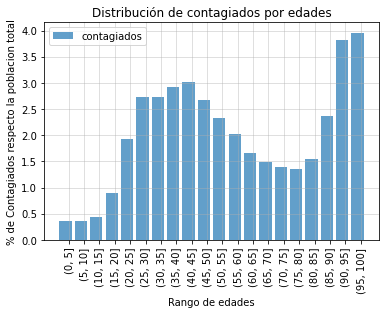

In [14]:
labels = df_etario['rango_edad']
contagiados = df_etario['contagiados']

x = np.arange(len(labels))
width = 0.4 # ancho de barras

fig, ax = plt.subplots()

bar_fallecidos = ax.bar(x - width/2, contagiados, label='contagiados', alpha=0.7)

ax.set_title('Distribución de contagiados por edades')
ax.set_ylabel('% de Contagiados respecto la poblacion total')
ax.set_xlabel('Rango de edades')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

ax.legend()

ax.grid(True, alpha=0.5)

Expliquemos el gráfico. En el eje **x** tenemos el rango de edades de la población de contagiados en categorias que van de 5 en 5. En el eje **y** tenemos al porcentaje de contagiados por rango etario, respecto a la población total de Argentina.

Podemos ver como el COVID-19 tiene un mayor impacto sobre los adultos mayores, esto se debe a que hay menos población en esos rangos.

Veamos un ejemplo tomando un rango cualquiera. Puede ser el de (30,35].

Si nos posicionamos sobre este, nos esta diciendo que el porcentaje o la población contagiada total que tiene entre 30 y 35 años es del 2.67% aproximadamente de esa misma categoria de la poblacion Argentina. Con numeros sería, la categoria 30-35 de la población total tiene 3.098.713 personas, si a esto lo multiplicamos por 2.67% (0.0267) tendremos a la población contagiada de ese rango. Los datos de la población total de Argentina la podemos ver en la siguiente tabla.


## Estudio de los fallecidos

Ahora obtengamos el dataframe de la poblacion de fallecidos por COVID-19 de Argentina.

In [15]:
## Dataframe fallecidos

df_edades = pd.cut(df_confirmados['edad'], bins=range(0,101,5)) # serie por rango de edades

df_fallecidos = df_confirmados[(df_confirmados['fallecido'] == 1)]

# Formamos dataframe de la poblacion de contagiados por edades y sexo. 
df_poblacion_fallecidos = pd.crosstab(df_edades, df_fallecidos['sexo'])
df_poblacion_fallecidos = df_poblacion_fallecidos.reset_index().drop(columns=['NR']) # Drop columna NR, datos no significativos.

# Transformando dataframe para correcto estudio. 
df_poblacion_fallecidos = df_poblacion_fallecidos.T.reset_index().T.rename(columns={0: 'rango_edad', 1: 'F', 2: 'M'}).drop('sexo')

# Columna nueva suma de la poblacion total por rangos de edades
df_poblacion_fallecidos['total'] = df_poblacion_fallecidos['F'] + df_poblacion_fallecidos['M']

### Normalizacion de los fallecidos
Teniendo la poblacion total de Argentina separada en rangos etarios dividimos la poblacion fallecida por COVID-19, de esta forma normalizaremos los datos para que no haya sesgo en nuestro analisis.

In [16]:
# Normalizacion
# Formamos nuevo dataframe para el estudio de la poblacion por rango de edades
df_etario_fallecidos = pd.DataFrame({
    'rango_edad': df_poblacion_fallecidos['rango_edad'],
    'fallecidos': (df_poblacion_fallecidos['total'] / df_poblacion['total'] * 100)})

Normalizados los datos, graficamos.

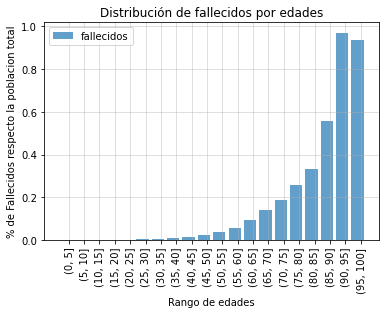

In [17]:
labels = df_etario_fallecidos['rango_edad']
fallecidos = df_etario_fallecidos['fallecidos']

x = np.arange(len(labels))
width = 0.4 # ancho de barras

fig, ax = plt.subplots()

bar_fallecidos = ax.bar(x - width/2, fallecidos, label='fallecidos', alpha=0.7)

ax.set_title('Distribución de fallecidos por edades')
ax.set_ylabel('% de Fallecidos respecto la poblacion total')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Rango de edades')
ax.legend()

ax.grid(True, alpha=0.5)

plt.show()

En este histograma vemos que la población más afectada por el COVID-19 en Argentina, y en todo el mundo, fue y es la adulta mayor a 60 años. Esto nos dice que en esta población deberiamos haber hecho hincapíe, ayudarla mas. A su vemos podemos ver los porcentajes de fallecidos respecto a la población total de Argentina.

El procedimiento para analizar estos es el mismo que el explicado en la gráfica anterior. Tomamos un rango de interés, obtenemos el porcentaje y lo multiplicamos por la población total de ese rango de la tabla de población total.

## Estudio de los contagiados y fallecidos

Ahora veamos la distribución de fallecidos que se encuetran sobre la distribución de contagiados. Con esto veremos el impacto de fallecidos que tiene el COVID-19 sobre la población infectada. 


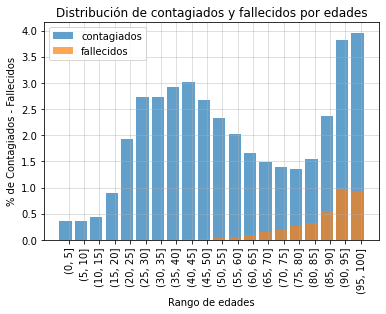

In [18]:
labels = df_etario['rango_edad']
contagiados = df_etario['contagiados']
fallecidos = df_etario_fallecidos['fallecidos']

x = np.arange(len(labels))
width = 0.4  # ancho de barras

fig, ax = plt.subplots()

bar_contagiados = ax.bar(x - width/2, contagiados, label='contagiados', alpha=0.7)
bar_fallecidos = ax.bar(x - width/2, fallecidos, label='fallecidos', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Distribución de contagiados y fallecidos por edades')
ax.set_ylabel('% de Contagiados - Fallecidos')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Rango de edades')

ax.legend()

ax.grid(True, alpha=0.5)

plt.show()

En este histograma podemos apreciar el impacto real que tiene el COVID-19 sobre la población. Expliquemos detalladamente que significa para elemento de nuestro gráfico. Las barras azules son los contagiados y las barras anaranjadas son los fallecidos. En el eje **x** tenemos el rango etario y en el eje **y** tenemos el porcentaje de contagiados y fallecidos respecto a la población total de Argentina.

La población mas afectada por este virus como dijimos antes es la adulta mayor a 60 años. Los grupos por encima de esta edad son los que corren y corrierón mayor riesgo de sufrir complicaciones graves o morir por esta condición. **Caso cerrado**.



## Analisis por rango etario y sexo

Para finalizar esta sección del estudio veamos quienes son mas afectados por el COVID-19, ¿los hombres o las mujeres?. Este ultimo apartado podría parecer una especie de competencia de quien aguanta mas este virus. Es interesante observar que parte de la población es mas afectada por el mismo.

Para llegar a diferentes conclusiones primero se obtuvo dos dataset de interés. Se extrayeron los datos del dataset en bruto, transformamos al mismo, lo normalizamos y graficamos.

In [19]:
# Normalizacion
# Formamos nuevo dataframe para el estudio de la poblacion por rango de edades y sexo.
df_etario_sexo = pd.DataFrame({'rango_edad': df_poblacion_contagiados['rango_edad'],
                         'M': (df_poblacion_contagiados['M'] / df_poblacion['M'] * 100),
                         'F': (df_poblacion_contagiados['F'] / df_poblacion['F'] * 100)})

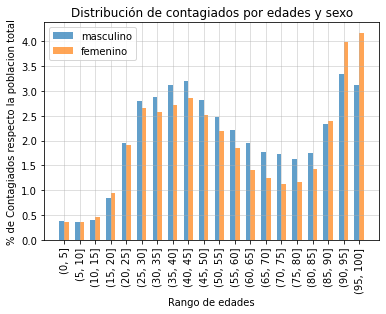

In [20]:
labels = df_etario_sexo['rango_edad']
masculino = df_etario_sexo['M']
femenino = df_etario_sexo['F']

x = np.arange(len(labels))
width = 0.3  # ancho de barras

fig, ax = plt.subplots()

bar_masculino = ax.bar(x - width/2, masculino, width, label='masculino', alpha=0.7)
bar_femenino = ax.bar(x + width/2, femenino, width, label='femenino', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Distribución de contagiados por edades y sexo')
ax.set_ylabel('% de Contagiados respecto la poblacion total')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Rango de edades')

ax.legend()

ax.grid(True, alpha=0.5)

plt.show()

In [28]:
# Porcentaje de contagiado en hombres y mujeres

total_contagiado = df_poblacion_contagiados['total'].sum()
porc_masculino = df_poblacion_contagiados['M'].sum() / total_contagiado * 100
porc_femenino = df_poblacion_contagiados['F'].sum() / total_contagiado * 100

porc_masculino, porc_femenino


(50.82152398652573, 49.17847601347427)

Podemos ver a simple vista en la curva de contagiados del COVID-19 que en general afecta mas a la población masculina. En porcentaje tenemos que el **50.82%** de la poblacion afectada por el COVID-19 es masculina y el **49.18%** es femenina. Veamos ahora la curva de fallecidos.


In [21]:
# Formamos nuevo dataframe para el estudio de la poblacion por rango de edades y sexo.
df_etario_sexo_fallecidos = pd.DataFrame({'rango_edad': df_poblacion_fallecidos['rango_edad'],
                         'M': (df_poblacion_fallecidos['M'] / df_poblacion['M'] * 100),
                         'F': (df_poblacion_fallecidos['F'] / df_poblacion['F'] * 100)})

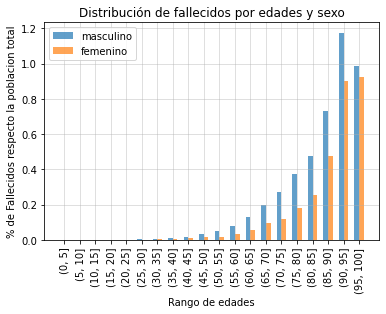

In [30]:
labels = df_etario_sexo_fallecidos['rango_edad']
masculino = df_etario_sexo_fallecidos['M']
femenino = df_etario_sexo_fallecidos['F']

x = np.arange(len(labels))
width = 0.3  # ancho de barras

fig, ax = plt.subplots()

bar_masculino = ax.bar(x - width/2, masculino, width, label='masculino', alpha=0.7)
bar_femenino = ax.bar(x + width/2, femenino, width, label='femenino', alpha=0.7)

ax.set_title('Distribución de fallecidos por edades y sexo')
ax.set_ylabel('% de Fallecidos respecto la poblacion total')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('Rango de edades')

ax.legend()

ax.grid(True, alpha=0.5)

plt.show()

In [29]:
# Porcentaje de fallecidos en hombres y mujeres

total_fallecidos = df_poblacion_fallecidos['total'].sum()
porc_masculino = df_poblacion_fallecidos['M'].sum() / total_fallecidos * 100
porc_femenino = df_poblacion_fallecidos['F'].sum() / total_fallecidos * 100

porc_masculino, porc_femenino


(56.958745764963794, 43.041254235036206)

Como veniamos viendo en el histograma anterior, a simple vista en la siguiente curva de fallecidos por COVID-19 afecta mas a la población masculina que a la femenina. En porcentaje tenemos que el **56.96%** de la poblacion afectada por el COVID-19 es masculina y el **43.04%** es femenina.